In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [38]:
df = pd.read_csv('GBPUSD_open_5year.csv')

In [39]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)

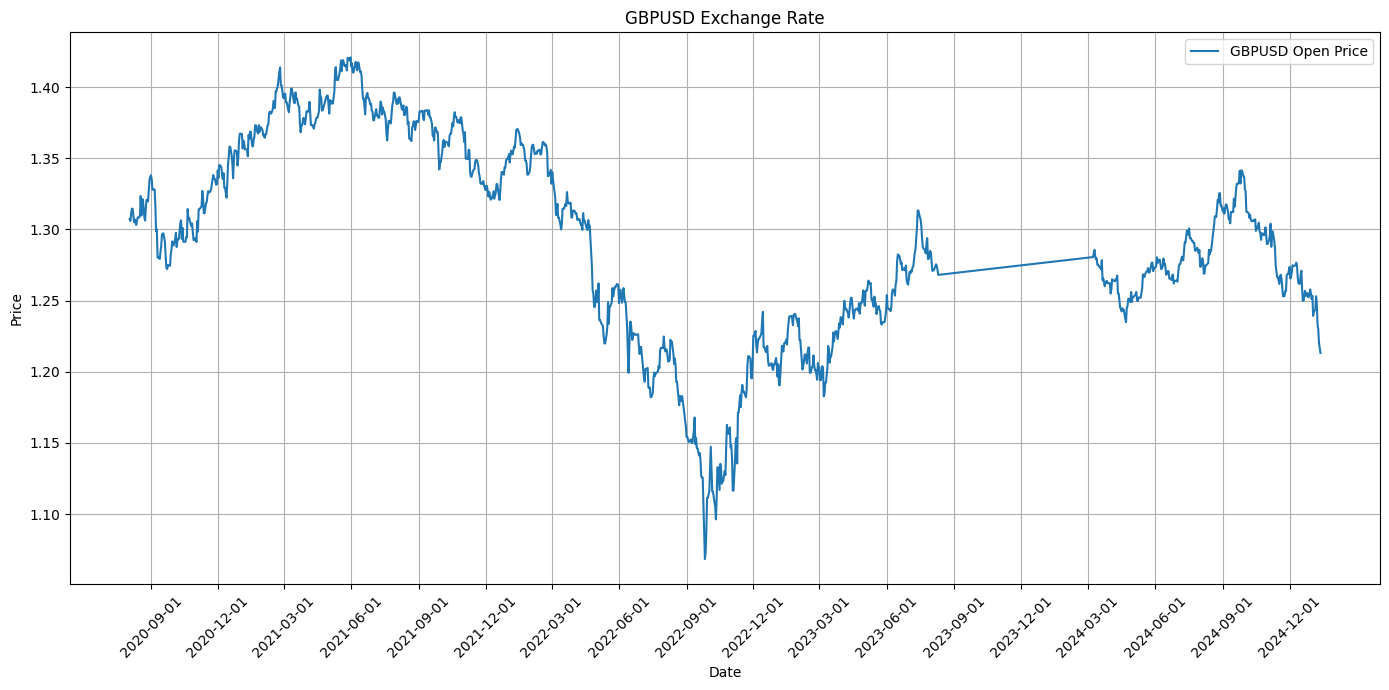

In [40]:
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')
plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
df.set_index('Date', inplace=True)

In [42]:
#train_ratio = 0.7
#val_ratio = 0.15
#test_ratio = 0.15

#train_size = int(len(df) * train_ratio)
#val_size = int(len(df) * val_ratio)
#test_size = len(df) - train_size - val_size

#train_data = df[:train_size]
#val_data = df[train_size:train_size + val_size]
#test_data = df[train_size + val_size:]

#print(f"Training Data: {train_data.shape}")
#print(f"Validation Data: {val_data.shape}")
#print(f"Test Data: {test_data.shape}")

In [43]:
train_data = df.iloc[:935]
remaining_data = df.iloc[935:]
validation_size = len(remaining_data) // 2

val_data = remaining_data.iloc[:validation_size]
test_data = remaining_data.iloc[validation_size:]

# Print the number of samples in each set
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

Training Data: 935 samples
Validation Data: 132 samples
Test Data: 133 samples


In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

target = 'Open'
y_val = val_data[target].values
y_test = test_data[target].values
y_train = train_data[target].values

X_train = scaler.transform(train_data[['Open', 'Time']])
X_val = scaler.transform(val_data[['Open', 'Time']])
X_test = scaler.transform(test_data[['Open', 'Time']])

In [45]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    for i in range(len(X) - time_interval): 
        X_range.append(X[i:i+time_interval])
        y_range.append(y[i+time_interval])
    return np.array(X_range), np.array(y_range)

In [46]:
time_steps = 60
X_train_cnn, y_train_cnn = time_sequence_generator(X_train, y_train, time_steps)
X_val_cnn, y_val_cnn = time_sequence_generator(X_val, y_val, time_steps)
X_test_cnn, y_test_cnn = time_sequence_generator(X_test, y_test, time_steps)

In [47]:
# Build the CNN model
cnn_model = Sequential()

# Convolutional layers with MaxPooling
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
cnn_model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))

cnn_model.add(Dropout(0.5))

# Flatten and Dense layers
cnn_model.add(Flatten())
#cnn_model.add(Dense(units=8, activation='relu'))
cnn_model.add(Dense(units=1))  # Output layer

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history_cnn = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))

Epoch 1/100


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6315 - mae: 0.6868 - mse: 0.6315 - val_loss: 0.1382 - val_mae: 0.3712 - val_mse: 0.1382
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1825 - mae: 0.3459 - mse: 0.1825 - val_loss: 0.1724 - val_mae: 0.4149 - val_mse: 0.1724
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1300 - mae: 0.2879 - mse: 0.1300 - val_loss: 0.1378 - val_mae: 0.3710 - val_mse: 0.1378
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0980 - mae: 0.2486 - mse: 0.0980 - val_loss: 0.1613 - val_mae: 0.4015 - val_mse: 0.1613
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0937 - mae: 0.2444 - mse: 0.0937 - val_loss: 0.1537 - val_mae: 0.3919 - val_mse: 0.1537
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0703 - mae: 0.2154 - mse: 0.0703 - val_loss: 0.1469 - val_mae: 0.3832 - val_mse: 0.1469
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0580 - mae: 0.1930 - mse: 0.0580 - val_loss: 0.1678 - 

In [48]:
# Evaluate the model on test data
test_loss_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"Test Loss (CNN): {test_loss_cnn}")

# Predict using the model
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Inverse transform predictions to get the actual values
y_pred_cnn_actual = scaler.inverse_transform(np.column_stack((y_pred_cnn, np.zeros(y_pred_cnn.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_cnn.reshape(-1, 1), np.zeros(y_test_cnn.shape))))[:, 0]

# Calculate performance metrics
mae_cnn = mean_absolute_error(y_test_actual, y_pred_cnn_actual)
mse_cnn = mean_squared_error(y_test_actual, y_pred_cnn_actual)
r2_cnn = r2_score(y_test_actual, y_pred_cnn_actual)
mape_cnn = np.mean(np.abs((y_test_actual - y_pred_cnn_actual) / y_test_actual)) * 100

print(f"CNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_cnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_cnn:.4f}")
print(f"R² Score: {r2_cnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_cnn:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - mae: 0.0298 - mse: 0.0012
Test Loss (CNN): [0.0009556718869134784, 0.026141038164496422, 0.0009556718869134784]
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BCFE68E790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
CNN Model Performance on Test Da

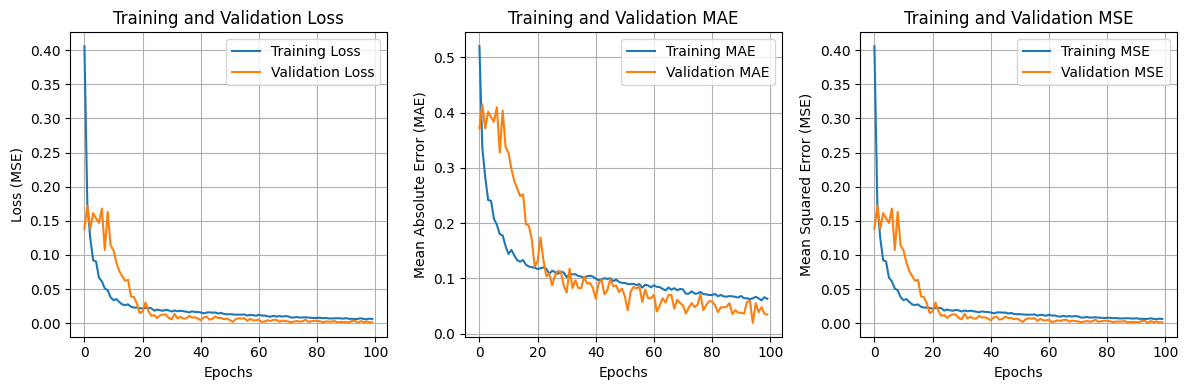

In [49]:
history_dict = history_cnn.history

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
def mean_directional_accuracy(actual, predicted):
    return np.mean((np.sign(np.diff(actual)) == np.sign(np.diff(predicted))).astype(int)) * 100

mda_cnn = mean_directional_accuracy(y_test_actual, y_pred_cnn_actual)

print(f"CNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_cnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_cnn:.4f}")
print(f"R² Score: {r2_cnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_cnn:.2f}%")
print(f"Mean Directional Accuracy (MDA): {mda_cnn:.2f}%")


CNN Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0092
Mean Squared Error (MSE): 0.0001
R² Score: -1.2188
Mean Absolute Percentage Error (MAPE): 0.61%
Mean Directional Accuracy (MDA): 41.67%
